In [1]:
from collections import defaultdict
import model
import pandas as pd
from collections import Counter
import numpy as np
from tqdm import tqdm

actual = {
    "dog_trainer": [
        {"dog": 0.422, "dalmatian": 0.567, "spotted_dog": 0.011},
        {"dalmatian": 0.978, "spotted_dog": 0.022},
        {"pug": 0.967, "small_dog": 0.033}],
    "child": [
        {"dog": 0.522, "dalmatian": 0.244, "spotted_dog": 0.233},
        {"dalmatian": 0.356, "spotted_dog": 0.644},
        {"pug": 0.5, "small_dog": 0.5}]}

contexts = [
    ["DALMATIAN", "CAT", "HORSE"],
    ["DALMATIAN", "PUG", "POODLE"],
    ["PUG", "DALMATIAN", "POODLE"]]


def get_total_variation_distance(actual, predicted):
    compare = []
    for word in set(actual.keys()).union(set(predicted.keys())):
        prob1 = predicted.get(word, 0)
        prob2 = actual.get(word, 0)
        compare.append(abs(prob1 - prob2))
    return sum(compare) / 2
    
    
def get_rank_score(actual, predicted):
    # TODO: make sure this is over the union
    # TODO: make this handle ties
    

    score_to_vals_actual = defaultdict(list)
    score_to_vals_predicted = defaultdict(list)
    for k, v in actual.items():
        if k not in predicted:
            continue
        score_to_vals_actual[v].append(k)
        # if k not in predicted:
        #     score_to_vals_predicted[0.0].append(k)
    for k, v in predicted.items():
        if k not in actual:
            continue
        score_to_vals_predicted[v].append(k)
        # if k not in actual:
        #     score_to_vals_actual[0.0].append(k)

    actual_ranking = [
        score_to_vals_actual[score]
        for score in sorted(score_to_vals_actual.keys())]
    predicted_ranking = [
        score_to_vals_predicted[score]
        for score in sorted(score_to_vals_predicted.keys())]
    # print(predicted_ranking)

    pred_rank_tier_i = 0
    j = 0
    for actual_rank_tier in actual_ranking:
        actual_remaining = actual_rank_tier[:]
        while actual_remaining != []:
            if j >= len(predicted_ranking[pred_rank_tier_i]):
                j = 0
                pred_rank_tier_i += 1
            found = False
            for item in predicted_ranking[pred_rank_tier_i]:
                # print(item)
                if item in actual_remaining:
                    actual_remaining.remove(item)
                    j += 1
                    found = True
            if not found:
                return 0
    return 1



assert 1 == get_rank_score(
    {"dog": 0.422, "dalmatian": 0.567, "spotted_dog": 0.011},
    {"dog": 0.15, "dalmatian": 0.8, "spotted_dog": 0.05})

assert 1 == get_rank_score(
    {"dog": 0.422, "dalmatian": 0.567, "spotted_dog": 0.011},
    {"dog": 0.1, "dalmatian": 0.8, "spotted_dog": 0.1})

assert 0 == get_rank_score(
    {"dog": 0.422, "dalmatian": 0.567, "spotted_dog": 0.011},
    {"dog": 0.05, "dalmatian": 0.8, "spotted_dog": 0.15})

assert 1 == get_rank_score(
    {"dog": 0.15, "dalmatian": 0.8, "spotted_dog": 0.05},
    {"dog": 0.422, "dalmatian": 0.567, "spotted_dog": 0.011})

assert 1 == get_rank_score(
    {"dog": 0.1, "dalmatian": 0.8, "spotted_dog": 0.1},
    {"dog": 0.422, "dalmatian": 0.567, "spotted_dog": 0.011})

assert 1 == get_rank_score(
    {"dog": 0.1, "dalmatian": 0.8, "spotted_dog": 0.1},
    {"dog": 0.11, "dalmatian": 0.567, "spotted_dog": 0.422})

assert 0 == get_rank_score(
    {"dog": 0.05, "dalmatian": 0.8, "spotted_dog": 0.15},
    {"dog": 0.422, "dalmatian": 0.567, "spotted_dog": 0.011})


In [16]:


a = get_total_variation_distance(
    {'pug': 0.5, 'small_dog': 0.5},
    {'pug': 0.004037296495728008,
     'small_dog': 0.9863089942568528,
     'dog': 0.009653709247419148})

b = get_total_variation_distance(
    {'dalmatian': 0.356, 'spotted_dog': 0.644},
{'dalmatian': 0.005690954021094229, 'spotted_dog': 0.9846713653728089, 'dog': 0.009637680606097015})

c = get_total_variation_distance(
    {'dog': 0.522, 'dalmatian': 0.244, 'spotted_dog': 0.233},
{'dalmatian': 0.0017078060419892622, 'spotted_dog': 0.2954913536332111, 'dog': 0.7028008403247996},)

(a + b + c) / 3

0.36302131448039615

In [2]:
# speaker_weights = np.arange(0, 1.1, 0.1)
# length_cost_params = np.arange(0, 6, 1)

# speaker_weights = np.arange(0, 1.1, 0.1)
# length_cost_params = np.arange(0, 1.1, 0.1)
# pragmatic_weight_params = np.arange(0, 1.1, 0.1)
# preferences_weight_params = np.arange(0, 1.1, 0.1)

speaker_weights = np.arange(0, 1.25, 0.25)
length_cost_params = np.arange(0, 1.25, 0.25)
pragmatic_weight_params = np.arange(0, 1.25, 0.25)
preferences_weight_params = np.arange(0, 1.25, 0.25)

lambdas = np.arange(1, 26, 1)


best_result = None
best_score = None

for speaker_weight in tqdm(speaker_weights):
    for length_cost in [False, True]:
        for lambda_val in lambdas:
            for pragmatic_weight in pragmatic_weight_params:
                for pref_weight in preferences_weight_params:
                    for length_cost_param in length_cost_params:
                        if length_cost is False and length_cost_param != length_cost_params[0]:
                            continue
                        lcp = length_cost_param
                        child_agent = model.Agent(
                            "child", lambda_param=lambda_val, 
                            speaker_weight=speaker_weight, length_cost_smoothing=lcp,
                            pref_weight=pref_weight, pragmatic_weight=pragmatic_weight)
                        adult_agent = model.Agent(
                            "general_adult", lambda_param=lambda_val, 
                            speaker_weight=speaker_weight, length_cost_smoothing=lcp,
                            pref_weight=pref_weight, pragmatic_weight=pragmatic_weight)
                        dog_trainer_agent = model.Agent(
                            "dog_trainer", lambda_param=lambda_val,
                            speaker_weight=speaker_weight, length_cost_smoothing=lcp,
                            pref_weight=pref_weight, pragmatic_weight=pragmatic_weight)

                        total_variation_child = []
                        total_variation_dog_trainer = []
                        rank_prop = []
                        for c, context in enumerate(contexts):
                            to_child = adult_agent.produce_matrix_mutant(
                                context, child_agent, length_cost=length_cost)
                            to_dog_trainer = adult_agent.produce_matrix_mutant(
                                context, dog_trainer_agent, length_cost=length_cost)

                            child_score = get_total_variation_distance(
                                actual["child"][c], to_child)
                            trainer_score = get_total_variation_distance(
                                actual["dog_trainer"][c], to_dog_trainer)

                            child_rank_score = get_rank_score(
                                actual["child"][c], to_child)
                            trainer_rank_score = get_rank_score(
                                actual["dog_trainer"][c], to_dog_trainer)

                            total_variation_child.append(child_score)
                            total_variation_dog_trainer.append(trainer_score)
                            rank_prop.extend([child_rank_score, trainer_rank_score])

                        total_variation_child = np.mean(total_variation_child)
                        total_variation_dog_trainer = np.mean(total_variation_dog_trainer)
                        rank_prop = np.mean(rank_prop)

                        total_variation_avg = np.mean(
                            [total_variation_child, total_variation_dog_trainer])

                        if best_score is None or total_variation_avg <= best_score:
                            best_score = total_variation_avg
                            best_result = {
                                "lambda": lambda_val,
                                "length cost": length_cost,
                                "length cost smoothing": lcp,
                                "speaker weight": speaker_weight,
                                "proportion correct ranking": rank_prop,
                                "result_trainer": total_variation_dog_trainer,
                                "result_child": total_variation_child,
                                "result_avg": total_variation_avg,
                                "pref_weight": pref_weight,
                                "pragmatic_weight": pragmatic_weight}

best_result


  0%|          | 0/5 [00:00<?, ?it/s]/home/jreneewatson/vocabulary-mismatch-model/model.py:186: RuntimeWarning: divide by zero encountered in log
  np.log(combined_listener[w, o]), np.NaN)
/home/jreneewatson/vocabulary-mismatch-model/model.py:191: RuntimeWarning: divide by zero encountered in log
  self.params["speaker weight"] * self.preferences[w, o]),
100%|██████████| 5/5 [01:38<00:00, 19.76s/it]


{'lambda': 5,
 'length cost': True,
 'length cost smoothing': 0.25,
 'speaker weight': 0.0,
 'proportion correct ranking': 0.6666666666666666,
 'result_trainer': 0.0479990755989749,
 'result_child': 0.09924624047758601,
 'result_avg': 0.07362265803828046,
 'pref_weight': 0.25,
 'pragmatic_weight': 1.0}

{'dalmatian': 0.1351771595194843, 'spotted_dog': 0.25598484425017426, 'dog': 0.6088379962303413}
{'dog': 0.522, 'dalmatian': 0.244, 'spotted_dog': 0.233}
[0]
[0, 1]
[0, 1, 2]


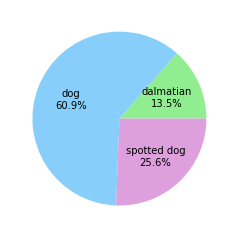




{'dalmatian': 0.48318814064376814, 'spotted_dog': 0.02751517461108315, 'dog': 0.4892966847451487}
{'dog': 0.422, 'dalmatian': 0.567, 'spotted_dog': 0.011}
[0]
[0, 1]
[0, 1, 2]


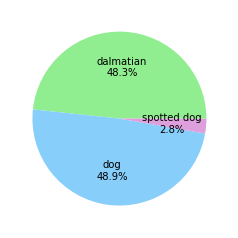




{'dalmatian': 0.3433790092165749, 'spotted_dog': 0.650256467183824, 'dog': 0.006364523599601122}
{'dalmatian': 0.356, 'spotted_dog': 0.644}
[0]
[0, 1]


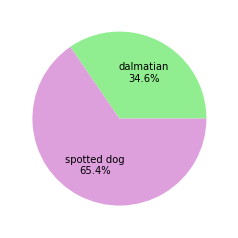




{'dalmatian': 0.9424073162796535, 'spotted_dog': 0.053665435222910965, 'dog': 0.003927248497435392}
{'dalmatian': 0.978, 'spotted_dog': 0.022}
[0]
[0, 1]


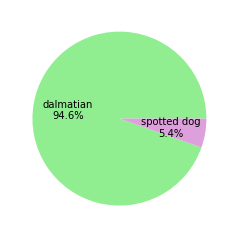




{'pug': 0.32420510983118267, 'small_dog': 0.6692445169895537, 'dog': 0.0065503731792636724}
{'pug': 0.5, 'small_dog': 0.5}
[0]
[0, 1]


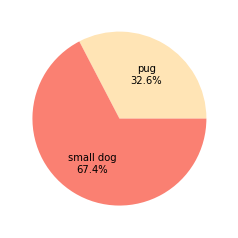




{'pug': 0.9424073162796535, 'small_dog': 0.053665435222910965, 'dog': 0.003927248497435392}
{'pug': 0.967, 'small_dog': 0.033}
[0]
[0, 1]


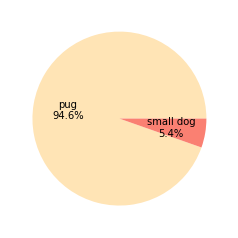

In [18]:
import visualizations

best_result = {'lambda': 5,
 'length cost': True,
 'length cost smoothing': 0.25,
 'speaker weight': 0.0,
 'proportion correct ranking': 0.6666666666666666,
 'result_trainer': 0.0479990755989749,
 'result_child': 0.09924624047758601,
 'result_avg': 0.07362265803828046,
 'pref_weight': 0.25,
 'pragmatic_weight': 1.0}

child_agent = model.Agent(
    "child",
    lambda_param=best_result["lambda"], 
    speaker_weight=best_result["speaker weight"],
    pref_weight=best_result["pref_weight"],
    pragmatic_weight=best_result["pragmatic_weight"],
    length_cost_smoothing=best_result["length cost smoothing"])
adult_agent = model.Agent(
    "general_adult",
    lambda_param=best_result["lambda"], 
    speaker_weight=best_result["speaker weight"],
    pref_weight=best_result["pref_weight"],
    pragmatic_weight=best_result["pragmatic_weight"],
    length_cost_smoothing=best_result["length cost smoothing"])
dog_trainer_agent = model.Agent(
    "dog_trainer",
    lambda_param=best_result["lambda"], 
    speaker_weight=best_result["speaker weight"],
    pref_weight=best_result["pref_weight"],
    pragmatic_weight=best_result["pragmatic_weight"],
    length_cost_smoothing=best_result["length cost smoothing"])

for c, context in enumerate(contexts):
    to_child = adult_agent.produce_matrix_mutant(
        context, child_agent, length_cost=best_result["length cost"])
    to_dog_trainer = adult_agent.produce_matrix_mutant(
        context, dog_trainer_agent, length_cost=best_result["length cost"])
    print(to_child)
    print(actual['child'][c])
    visualizations.make_pie_plot(to_child)
    print("\n\n")
    
    print(to_dog_trainer)
    print(actual['dog_trainer'][c])
    visualizations.make_pie_plot(to_dog_trainer)
    print("\n\n")


In [4]:
length_cost_params = np.arange(0, 10, 1)
# lambdas = [1]
contexts = [
    ["DALMATIAN", "CAT", "HORSE"],
    ["DALMATIAN", "PUG", "POODLE"],
    ["PUG", "DALMATIAN", "POODLE"]]

best_result = None
best_score = None
for lambda_val in lambdas:
    adult_agent = model.Agent("general_adult", lambda_param=lambda_val)
    
    total_variation_child = []
    total_variation_dog_trainer = []
    rank_prop = []
    for c, context in enumerate(contexts):
        produce = adult_agent.produce_matrix_plain(context)

        child_score = get_total_variation_distance(
            actual["child"][c], produce)
        trainer_score = get_total_variation_distance(
            actual["dog_trainer"][c], produce)

        child_rank_score = get_rank_score(
            actual["child"][c], produce)
        trainer_rank_score = get_rank_score(
            actual["dog_trainer"][c], produce)

        total_variation_child.append(child_score)
        total_variation_dog_trainer.append(trainer_score)
        rank_prop.extend([child_rank_score, trainer_rank_score])

    total_variation_child = np.mean(total_variation_child)
    total_variation_dog_trainer = np.mean(total_variation_dog_trainer)
    rank_prop = np.mean(rank_prop)

    total_variation_avg = np.mean(
        [total_variation_child, total_variation_dog_trainer])

    if best_score is None or total_variation_avg <= best_score:
        best_score = total_variation_avg
        best_result = {
            "lambda": lambda_val,
            "proportion correct ranking": rank_prop,
            "result_trainer": total_variation_dog_trainer,
            "result_child": total_variation_child,
            "result_avg": total_variation_avg}


best_result

/home/jreneewatson/vocabulary-mismatch-model/model.py:117: RuntimeWarning: divide by zero encountered in log
  utility = np.where(listener[w, o] > 0.00001, np.log(listener[w, o]), np.NaN)


{'lambda': 25,
 'proportion correct ranking': 1.0,
 'result_trainer': 0.42244444444464113,
 'result_child': 0.11105555555585062,
 'result_avg': 0.26675000000024585}

{'dalmatian': 0.3333333333333333, 'spotted_dog': 0.3333333333333333, 'dog': 0.3333333333333333}
{'dog': 0.522, 'dalmatian': 0.244, 'spotted_dog': 0.233}
{'dog': 0.422, 'dalmatian': 0.567, 'spotted_dog': 0.011}
[0]
[0, 1]
[0, 1, 2]


/home/jreneewatson/vocabulary-mismatch-model/model.py:117: RuntimeWarning: divide by zero encountered in log
  utility = np.where(listener[w, o] > 0.00001, np.log(listener[w, o]), np.NaN)


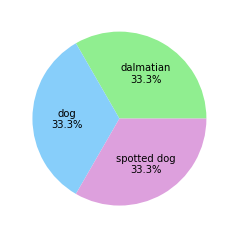




{'dalmatian': 0.4999999999997049, 'spotted_dog': 0.4999999999997049, 'dog': 5.901176935783424e-13}
{'dalmatian': 0.356, 'spotted_dog': 0.644}
{'dalmatian': 0.978, 'spotted_dog': 0.022}
[0]
[0, 1]


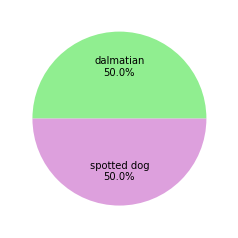




{'pug': 0.4999999999997049, 'small_dog': 0.4999999999997049, 'dog': 5.901176935783424e-13}
{'pug': 0.5, 'small_dog': 0.5}
{'pug': 0.967, 'small_dog': 0.033}
[0]
[0, 1]


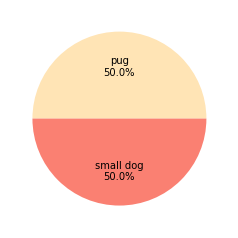

In [5]:
best_result = {'lambda': 25,
 'proportion correct ranking': 1.0,
 'result_trainer': 0.42244444444444523,
 'result_child': 0.11105555555555678,
 'result_avg': 0.266750000000001}

adult_agent = model.Agent("general_adult", lambda_param=lambda_val)

for c, context in enumerate(contexts):
    produce = adult_agent.produce_matrix_plain(context)

    print(produce)
    print(actual['child'][c])
    print(actual['dog_trainer'][c])
    visualizations.make_pie_plot(produce)

    print("\n\n")
